In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip /content/drive/MyDrive/colab/images.zip
# !pip install wandb

In [2]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

import wandb

In [3]:
def set_seed(seed):
    # torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
# warnings.filterwarnings("ignore")
set_seed(3407)
wandb.login()

# model.zero_grad()
# loss.backward()
# optimizer.step()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: seara. Use `wandb login --relogin` to force relogin


True

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATAROOT = (
    "/home/seara/Desktop/Github/vk-try/images"
    if os.path.isdir("/home/seara/Desktop/Github/vk-try/images")
    else "/content/images"
)
WORKERS = 4
BATCH_SIZE = 64
NUM_EPOCHS = 2000
LR = 1e-4
BETA1 = 0
BETA2 = 0.9
IMAGE_SIZE = (64, 64)
LATENT_DIM = 100
FEATURES = 64
LAMBDA_GP = 10
DISCRIMINATOR_ITERATIONS = 5

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, features):
        super().__init__()
        self.net = nn.Sequential(
            *self.block(latent_dim, features * 16, 4, 1, 0),
            *self.block(features * 16, features * 8, 4, 2, 1),
            *self.block(features * 8, features * 4, 4, 2, 1),
            *self.block(features * 4, features * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                in_channels=features * 2,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=True,
            ),
            nn.Tanh(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=features,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=True,
            ),
            nn.LeakyReLU(0.2, inplace=True),
            *self.block(features, features * 2, 4, 2, 1),
            *self.block(features * 2, features * 4, 4, 2, 1),
            *self.block(features * 4, features * 8, 4, 2, 1),
            nn.Conv2d(
                in_channels=features * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=True,
            ),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [8]:
class DCGAN:
    def __init__(
        self,
        num_epochs,
        lr,
        beta1,
        beta2,
        latent_dim,
        features,
        lambda_gp,
        discriminator_iterations,
        device,
    ):

        self.num_epochs = num_epochs
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.latent_dim = latent_dim
        self.features = features
        self.lambda_gp = lambda_gp
        self.discriminator_iterations = discriminator_iterations
        self.device = device

        self.G = Generator(self.latent_dim, self.features)
        self.D = Discriminator(self.features)

        self.G.to(self.device)
        self.D.to(self.device)

        self.initialize_weights(self.G)
        self.initialize_weights(self.D)

        self.loss = nn.BCELoss()

        self.d_optimizer = optim.Adam(
            self.D.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )
        self.g_optimizer = optim.Adam(
            self.G.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )

    def train(self, dataloader):
        wandb.init(project="vk_try", name="WGAN-GP FULL")
        # wandb.watch(model)

        self.G.train()
        self.D.train()

        for epoch in range(self.num_epochs):
            d_loss_list = []
            g_loss_list = []
            for i, (real_images, _) in enumerate(dataloader):
                real_images = real_images.to(self.device)

                for _ in range(self.discriminator_iterations):
                    self.D.zero_grad()

                    noise = torch.randn(
                        (real_images.size(0), self.latent_dim, 1, 1), device=self.device
                    )
                    g_output = self.G(noise)

                    d_real_output = self.D(real_images).flatten()
                    d_fake_output = self.D(g_output.detach()).flatten()
                    gp = self.gradient_penalty(real_images, g_output, self.device)

                    d_loss = (
                        -(torch.mean(d_real_output) - torch.mean(d_fake_output))
                        + self.lambda_gp * gp
                    )
                    d_loss.backward()
                    self.d_optimizer.step()
                    d_loss_list.append(d_loss.item())

                # Generator step
                self.G.zero_grad()
                noise = torch.randn(
                    (real_images.size(0), self.latent_dim, 1, 1), device=self.device
                )
                g_output = self.G(noise)
                d_fake_output = self.D(g_output).flatten()
                g_loss = -torch.mean(d_fake_output)
                g_loss.backward()
                self.g_optimizer.step()

                # Logging
                
                g_loss_list.append(g_loss.item())

            if epoch % 100 == 0:
                images_count = 32
                gen_images = self.generate(images_count)
                plt.figure(figsize=(15, 15))
                plt.axis("off")
                plt.title("Fake Images")
                plt.imshow(
                    make_grid(
                        gen_images[:images_count].cpu(), padding=2, normalize=True
                    ).permute(1, 2, 0)
                )
                plt.show()
                self.G.train()
                self.D.train()
                path = (
                    f"/home/seara/Desktop/Github/vk-try/finalmodel{epoch}.pt"
                    if os.path.isdir("/home/seara/Desktop/Github/vk-try")
                    else f"/content/drive/MyDrive/colab/finalmodel{epoch}.pt"
                )
                self.save(path)

            metrics = {
                "d_loss": sum(d_loss_list) / len(d_loss_list),
                "g_loss": sum(g_loss_list) / len(g_loss_list),
            }
            print(f"Epoch: {epoch}: {metrics}")
            wandb.log(metrics)

    def generate(self, images_count):
        self.D.eval()
        self.G.eval()
        with torch.no_grad():
            noise = torch.randn(images_count, 100, 1, 1, device=self.device)
            return self.G(noise).detach()

    def gradient_penalty(self, real, fake, device):
        batch_size, c, h, w = real.shape
        alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
        interpolated_images = real * alpha + fake * (1 - alpha)

        # Calculate critic scores
        mixed_scores = self.D(interpolated_images)

        # Take the gradient of the scores with respect to the images
        gradient = torch.autograd.grad(
            inputs=interpolated_images,
            outputs=mixed_scores,
            grad_outputs=torch.ones_like(mixed_scores),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradient = gradient.view(gradient.shape[0], -1)
        gradient_norm = gradient.norm(2, dim=1)
        gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
        return gradient_penalty

    def initialize_weights(self, model):
        for m in model.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def save(self, path):
        save_dict = {
            "discriminator": self.D.state_dict(),
            "generator": self.G.state_dict(),
            "d_optimizer": self.d_optimizer.state_dict(),
            "g_optimizer": self.g_optimizer.state_dict(),
        }
        torch.save(save_dict, path)

    def load(self, path):
        load_dict = torch.load(path)

        if "generator" in load_dict:
            print("Loaded gen")
            self.G.load_state_dict(load_dict["generator"])
        if "discriminator" in load_dict:
            print("Loaded dis")
            self.D.load_state_dict(load_dict["discriminator"])
        if "d_optimizer" in load_dict:
            print("Loaded d_opt")
            self.d_optimizer.load_state_dict(load_dict["d_optimizer"])
        if "g_optimizer" in load_dict:
            print("Loaded g_opt")
            self.g_optimizer.load_state_dict(load_dict["g_optimizer"])

In [9]:
dataset = ImageFolder(
    root=DATAROOT,
    transform=transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE),
            transforms.ColorJitter(saturation=1, hue=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
dataloader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS
)

In [10]:
model = DCGAN(
    NUM_EPOCHS,
    LR,
    BETA1,
    BETA2,
    LATENT_DIM,
    FEATURES,
    LAMBDA_GP,
    DISCRIMINATOR_ITERATIONS,
    DEVICE,
)
model.train(dataloader)

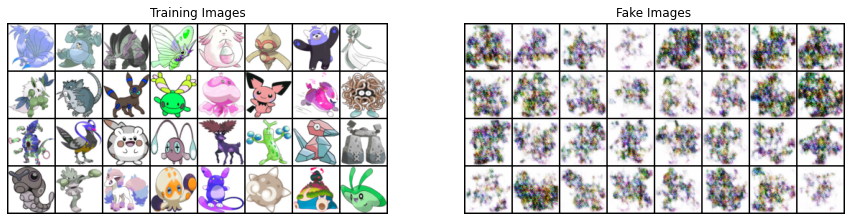

In [ ]:
images_count = 32
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    make_grid(
        next(iter(dataloader))[0][:images_count], padding=2, normalize=True
    ).permute(1, 2, 0)
)

gen_images = model.generate(images_count)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(make_grid(gen_images.cpu(), padding=2, normalize=True).permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


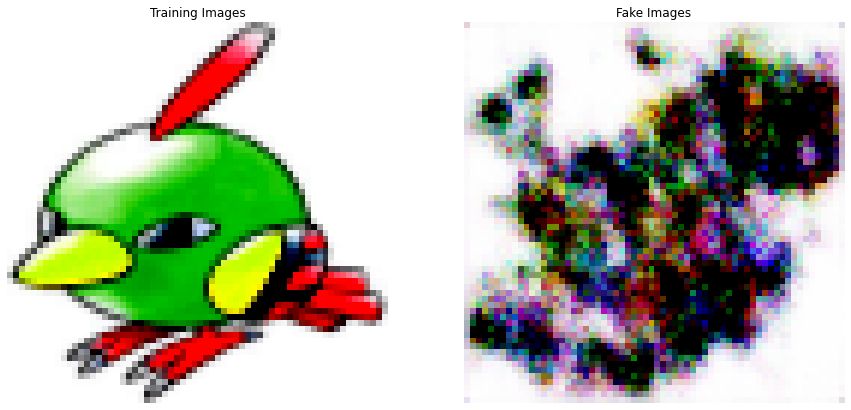

In [ ]:
images_count = 1
image = next(iter(dataloader))[0]
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(image[0].permute(1, 2, 0))

gen_images = model.generate(images_count)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(gen_images[0].cpu().permute(1, 2, 0))
plt.show()